## PoC Case study

Created: 19 December 2023<br>
Modified: 13 May 2024 <br>
Changes. Update to accomodate change in inventory and associated terminal category derivation.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
df = pd.read_excel(interim_dir+'final_updated_universe_130524.xlsx', index_col = [0] )


In [4]:
df.final_centroid.nunique()

128

In [5]:
df

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,ANALYTICAL_MTHDS,DISCHARGE,DRINKING_WATER,DRINKING_WATER-UCMR,ENV_MEDIA,PROD_DATA,TRI-OFFSITE,TRI-ONSITE,TRI_WASTE,pubmed_avail
0,IROQAHVXXUQBOS-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCN(CCNC(=O)c1ccc(Cc2ccc(C(O)=O)cc2)cc1)S(=O)...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID90897582,DSSTox_High,4-(Perfluorononyl)oxybenzenesulfonate sodium,91998-13-9,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C1=CC=C(OC(F)(F)C(F)(F)C(F)...,"InChI=1S/C15H5F19O4S.Na/c16-7(17,8(18,19)10(22...",WEKFOCTWTWPVEG-UHFFFAOYSA-M,C15H4F19NaO4S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,DTXSID90896257,Public_Low,(2S)-2-{Bis[4-(heptadecafluorooctyl)phenyl][(t...,914391-37-0,Single Compound,NaN,CC[Si](CC)(CC)OC([C@@H]1CCCN1)(C1=CC=C(C=C1)C(...,"InChI=1S/C39H31F34NOSi/c1-4-76(5-2,6-3)75-23(2...",PARYPNCCAOUHML-QFIPXVFZSA-N,C39H31F34NOSi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,DTXSID90896196,Public_Low,"2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecaflu...",157584-47-9,Single Compound,NaN,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,"InChI=1S/C21H10F17NO/c22-14(23,13(40)39(11-7-3...",IDJHICNQDCLWAB-UHFFFAOYSA-N,C21H10F17NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,DTXSID90896095,Public_Low,"3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadeca...",113823-56-6,Single Compound,NaN,CC1=CC=C(C=C1)S(=O)(=O)OCCC(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C17H11F17O3S/c1-8-2-4-9(5-3-8)38(35,3...",WGCSEECKLMOBLT-UHFFFAOYSA-N,C17H11F17O3S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15520,ZIQDQEQBQRGFDF-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCC[P+](CCCC)(CCCC)(CC(C)=O).[N-](C)S(=O)(=O)...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15521,ZKYPCYQMVQMYAB-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCC[P+](CCCC)(CCCC)(CC(O)CC(O)=O).[O-]S(=O)(=...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15522,ZOJATUBFKQLTCD-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCCOP(C)(=O)(CCCC).OS(=O)(=O)C(F)(F)C(F)(F)C(...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15523,ZRONJOSZRXLGCA-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCCP(O)(=O)(CCCC).OS(=O)(=O)C(F)(F)C(F)(F)C(F...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import sys

In [7]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [8]:
from model_functions import *

In [9]:
tsne_df = df[['dtxsid','Substance_Name', 'smiles','TSCA_STATUS', 'chain_length', 'test_track','MolWeight', 'BP_pred', 'LogVP_pred','MP_pred', 'LogP_pred', 'HLC', 'WS_pred_mol/L', 'WS_pred_mg/L', 'final_centroid', 'final_dist', 'group', 'group_str',
       'MaxMin_picks', 'tsca_centroid', 'tsca_centroid_id',
       'tsca_centroid_id2', 'tsca_analogues', 'tsca_dist', 'MaxMin_tsca_picks',
       'tsca_active_centroid', 'tsca_active_centroid_id',
       'tsca_active_centroid_id2', 'tsca_active_analogues', 'tsca_active_dist',
       'MaxMin_tsca_active_picks']].copy()

In [10]:
[e for e in tsne_df.columns.tolist() if 'tsca' in e]

['tsca_centroid',
 'tsca_centroid_id',
 'tsca_centroid_id2',
 'tsca_analogues',
 'tsca_dist',
 'MaxMin_tsca_picks',
 'tsca_active_centroid',
 'tsca_active_centroid_id',
 'tsca_active_centroid_id2',
 'tsca_active_analogues',
 'tsca_active_dist',
 'MaxMin_tsca_active_picks']

In [11]:
tsne_df['final_centroid_tag'] = tsne_df['dtxsid'].apply(lambda x: 1 if x in tsne_df.final_centroid.unique() else np.nan)

In [12]:
tsne_df1 = tsne_df.set_index('dtxsid')

In [13]:

tsne_df1['MaxMin_picks'] = tsne_df1['MaxMin_picks'].replace(0,np.nan)
tsne_df1['MaxMin_tsca_picks'] = tsne_df1['MaxMin_tsca_picks'].replace(0,np.nan)
tsne_df1['tsca_centroid_tag'] = tsne_df1['tsca_centroid'].replace('centroid',1)
tsne_df1['tsca_centroid_tag'] = tsne_df1['tsca_centroid_tag'].replace(1, "tsca_centroid")
tsne_df1['final_centroid_tag'] = tsne_df1['final_centroid_tag'].replace(1,'centroid')
tsne_df1['MaxMin_tsca_picks'] = tsne_df1['MaxMin_tsca_picks'].replace(1,"tsca_maxmin")
tsne_df1['MaxMin_picks'] = tsne_df1['MaxMin_picks'].replace(1,"maxmin")





In [14]:
tsne_df1['MaxMin_tsca_active_picks'] = tsne_df1['MaxMin_tsca_active_picks'].replace(0,np.nan)
tsne_df1['tsca_active_centroid_tag'] = tsne_df1['tsca_active_centroid'].replace('centroid',1)
tsne_df1['tsca_active_centroid_tag'] = tsne_df1['tsca_active_centroid_tag'].replace(1, "tsca_active_centroid")

In [15]:
tsne_df1['MaxMin_tsca_active_picks'] = tsne_df1['MaxMin_tsca_active_picks'].replace(1, "tsca_active_maxmin")

In [16]:
tsne_df1[['MaxMin_tsca_active_picks','tsca_active_centroid_tag']].sort_values(by = 'MaxMin_tsca_active_picks')

,MaxMin_tsca_active_picks,tsca_active_centroid_tag
dtxsid,,
DTXSID7046548,tsca_active_maxmin,tsca_active_centroid
DTXSID60556977,tsca_active_maxmin,NaN
DTXSID00880147,tsca_active_maxmin,NaN
DTXSID7067328,tsca_active_maxmin,NaN
DTXSID3059927,tsca_active_maxmin,NaN
...,...,...
ZIQDQEQBQRGFDF-UHFFFAOYSA-N,NaN,NaN
ZKYPCYQMVQMYAB-UHFFFAOYSA-N,NaN,NaN
ZOJATUBFKQLTCD-UHFFFAOYSA-N,NaN,NaN


In [17]:
universe_dict = {}
for i,group in tsne_df1.groupby('group_str'):
    universe_dict[i] = group

In [18]:
import pickle

# open a file, where you stored the pickled data
file = open(interim_dir+'umap_lst_120524.pkl', 'rb')

# dump information to that file
umap_lst = pickle.load(file)

# close the file
file.close()

In [19]:
mylst = []
for i in range(len(umap_lst)):
    mylst.append(umap_lst[i]['label'])

In [20]:
umap_all = {}
for i in range(len(umap_lst)):
    for e in mylst:
        if umap_lst[i]['label'] == e:
            a = pd.concat([umap_lst[i]['umap'], universe_dict[e]], axis = 1)
            umap_all[e] = a

In [21]:
umap_all_dict = {}
for k,v in umap_all.items():
    a = umap_all[k].reset_index()
    b = pd.melt(a, id_vars = ['index', 'umap_x', 'umap_y'], value_vars = ['final_centroid_tag', 'tsca_active_centroid_tag', 'MaxMin_tsca_active_picks','MaxMin_tsca_picks','tsca_centroid_tag', 'MaxMin_picks',  ])
    b = b.dropna(subset=['value']).drop_duplicates(subset = 'index', keep = 'first')
    umap_all_dict[k] = a,b

In [22]:
color_dict2 = dict({'centroid':'green',
                  'maxmin':'yellow',
                  'tsca_maxmin': 'orange',
                   'tsca_centroid': 'red',
                   'tsca_active_centroid': 'blue',
                   'tsca_active_maxmin': 'black'})

In [26]:
umap_all_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"][0][['index',
 'umap_x',
 'umap_y',
    'final_centroid_tag', 
                                                          'TSCA_STATUS',
 'tsca_centroid',
 'MaxMin_tsca_picks',
    'MaxMin_tsca_active_picks','tsca_active_centroid_tag'                                                      
                                                         ]].head()

,index,umap_x,umap_y,final_centroid_tag,TSCA_STATUS,tsca_centroid,MaxMin_tsca_picks,MaxMin_tsca_active_picks,tsca_active_centroid_tag
0,DTXSID70884511,-2.272066,5.908141,centroid,inactive,centroid,tsca_maxmin,NaN,NaN
1,DTXSID90896530,-1.210154,8.949283,NaN,unclassified,NaN,NaN,NaN,NaN
2,DTXSID90888859,-1.534644,6.738773,NaN,inactive,NaN,NaN,NaN,NaN
3,DTXSID90886254,-1.312082,7.819004,NaN,unclassified,NaN,NaN,NaN,NaN
4,DTXSID80896620,-0.518380,-5.307733,NaN,unclassified,NaN,NaN,NaN,NaN


In [27]:
umap_all_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"][0].shape

(56, 36)

In [29]:
umap_all_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"][1]

,index,umap_x,umap_y,variable,value
0,DTXSID70884511,-2.272066,5.908141,final_centroid_tag,centroid
66,DTXSID60880406,12.118006,13.607481,tsca_active_centroid_tag,tsca_active_centroid
123,DTXSID60862823,-0.819327,7.880511,MaxMin_tsca_active_picks,tsca_active_maxmin
127,DTXSID50862736,-1.646271,7.869435,MaxMin_tsca_active_picks,tsca_active_maxmin
138,DTXSID2044630,-2.122389,6.347294,MaxMin_tsca_active_picks,tsca_active_maxmin
173,DTXSID80880185,-0.618524,-4.690335,MaxMin_tsca_picks,tsca_maxmin
196,DTXSID10886372,12.198949,13.855048,MaxMin_tsca_picks,tsca_maxmin
299,DTXSID40787060,-1.622036,8.458918,MaxMin_picks,maxmin
307,DTXSID201026203,-0.705304,8.057211,MaxMin_picks,maxmin


In [37]:
universe_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"].columns

Index(['Substance_Name', 'smiles', 'TSCA_STATUS', 'chain_length', 'test_track',
       'MolWeight', 'BP_pred', 'LogVP_pred', 'MP_pred', 'LogP_pred', 'HLC',
       'WS_pred_mol/L', 'WS_pred_mg/L', 'final_centroid', 'final_dist',
       'group', 'group_str', 'MaxMin_picks', 'tsca_centroid',
       'tsca_centroid_id', 'tsca_centroid_id2', 'tsca_analogues', 'tsca_dist',
       'MaxMin_tsca_picks', 'tsca_active_centroid', 'tsca_active_centroid_id',
       'tsca_active_centroid_id2', 'tsca_active_analogues', 'tsca_active_dist',
       'MaxMin_tsca_active_picks', 'final_centroid_tag', 'tsca_centroid_tag',
       'tsca_active_centroid_tag'],
      dtype='object')

[<matplotlib.collections.PathCollection object at 0x7ba7d325e850>, <matplotlib.collections.PathCollection object at 0x7ba7d3255820>, <matplotlib.collections.PathCollection object at 0x7ba7d33988b0>, <matplotlib.collections.PathCollection object at 0x7ba7d3247880>, <matplotlib.collections.PathCollection object at 0x7ba7d325edc0>] ['centroid', 'tsca_active_centroid', 'tsca_active_maxmin', 'tsca_maxmin', 'maxmin']


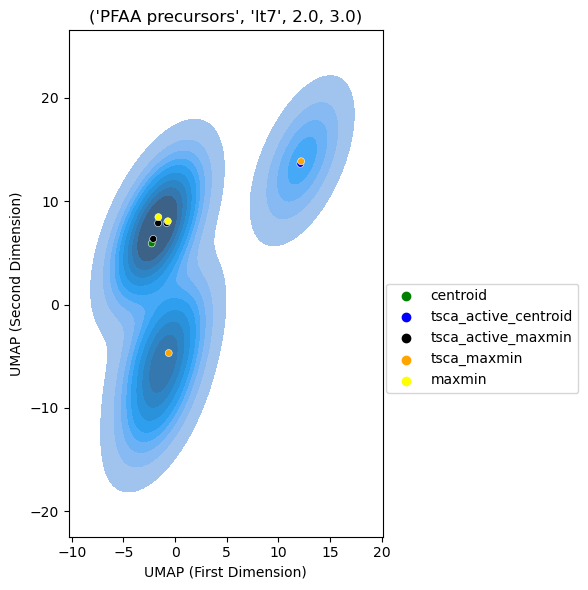

In [34]:
f, ax1 = plt.subplots(figsize = (6,6))
plt.subplots_adjust(hspace = 0.8)
colors = {1:'red', 0 : 'blue'}

ax1.title.set_text("('PFAA precursors', 'lt7', 2.0, 3.0)")
#grouped = tsne_df.groupby('Source')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='tsne_x', y='tsne_y', alpha = alphas[0], label=key, color=colors[key])
ax1 = sns.kdeplot(x="umap_x", y="umap_y", fill = True, data=umap_all_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"][0], ax = ax1,  )
ax1 = sns.scatterplot(x="umap_x", y="umap_y",  hue = 'value', s = 25, hue_order = ['centroid', 'tsca_active_centroid', 'tsca_active_maxmin', 'tsca_maxmin', 'maxmin'] , color=[0.75,0.5,0], data=umap_all_dict["('PFAA precursors', 'lt7', 2.0, 3.0)"][1], ax = ax1,palette = color_dict2)
handles, labels = ax1.get_legend_handles_labels()
print(handles, labels)
l = plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1.01, 0.5), loc=2, borderaxespad=0.)
ax1.set_xlabel('UMAP (First Dimension)')
ax1.set_ylabel('UMAP (Second Dimension)')
plt.tight_layout()
f.savefig(figures_dir+'Figure15_case_study_130524.png', dpi = 300)

In [35]:
import pickle
pickle.dump( umap_all_dict, open(interim_dir+ "umap_all_dict_130524.pkl", "wb" ) )
pickle.dump( umap_all, open(interim_dir+ "umap_all_universe_130524.pkl", "wb" ) )